# 2024-02-29 webinar Respect the pump, Intraday crypto seasonality DELTA
- video https://robotwealth.com/rw-pro-webinar-2024-02-29-respecting-the-pump/
- blog post https://robotwealth.com/rw-pro-weekly-update-1-march-2024-respect-the-pump-intraday-crypto-seasonality-constant-maturity-futures/
- notebook https://github.com/RWLab/crypto-pod/blob/main/research/intraday_seasonal_patterns.ipynb

## Load Libraries

In [2]:
# pacman::p_load_current_gh("Robot-Wealth/rsims", dependencies = TRUE)
pacman::p_load_current_gh("RWLab/rwRtools", dependencies = TRUE)

options(repr.plot.width = 14, repr.plot.height=7, warn = -1)

library(tidyverse)
library(tibbletime)
library(roll)
library(patchwork)

# chart options
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘tibbletime’


The following object is masked from ‘package:stats’:

    filter




## Load Crypto Data

In [3]:
Sys.setenv(TZ = 'UTC')
Sys.timezone()
rwlab_data_auth()
# load binance prices
raw_prices <- rwRtools::crypto_get_binance_spot_1h()

[1] "UTC"

Authorization successful!

ℹ Downloading binance_spot_1h.feather

✔ Saved binance_spot_1h.feather to binance/binance_spot_1h.feather  ( 914 Mb )





File successfully transferred


In [4]:
# filter last BTCUSDT data rows to compare with other data sources
raw_prices %>%
  filter(Ticker == "BTCUSDT") %>%
  head()

Ticker,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
BTCUSDT,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,202366.138,171,35.160503,150952.478
BTCUSDT,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,100304.824,102,21.448071,92608.280
BTCUSDT,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,31282.313,36,4.802861,20795.317
BTCUSDT,2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,19241.058,25,2.602292,11291.347
BTCUSDT,2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,4239.504,28,0.814655,3552.747
BTCUSDT,2017-08-17 09:00:00,4360.00,4445.78,4360.00,4444.00,10.763623,47219.356,43,10.258400,44995.378


## Remove Stables, Wrapped Coins

In [5]:
# remove LUNAUSDT from Friday 13 May 2022. Even though it continued to exist after this, there's no way you'd include it in your universe of tradable assets.
prices <- raw_prices %>%
  filter(!(Ticker == "LUNAUSDT" & Datetime >= "2022-05-13"))

# prices %>% head

Make a sensible universe - remove stables, wrapped coins, leveraged tokens. Take top n by rolling 30-day dollar volume.

In [6]:
library(httr)
# ditch stables and wrapped/leveraged tokens and keep only the data we need

# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

stables <- glue::glue("{stables}USDT")

# duplicates and others to remove
to_remove <- glue::glue("{c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3', 'WNXM', 'WBTC', 'BNBBULL', 'BNBBEAR', 'EOSBULL', 'EOSBEAR', 'ETHBULL', 'ETHBEAR', 'XRPBULL', 'XRPBEAR')}USDT")

# Remove stablecoins and others
prices <- prices %>%
  filter(!Ticker %in% c(stables, to_remove)) %>%
  mutate(Ticker = str_replace(Ticker, "USDT$", ""))

head(prices)

Ticker,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
BTC,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,202366.14,171,35.160503,150952.48
ETH,2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.668770,37684.80,129,80.563770,24193.44
BTC,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,100304.82,102,21.448071,92608.28
ETH,2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.672460,114043.28,202,328.104280,99079.80
BTC,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,31282.31,36,4.802861,20795.32
ETH,2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.866720,92034.44,182,259.286680,78525.95


## Take top n by rolling 30-day dollar volume

In [137]:
# limit universe
trading_universe_size <- 10

universe <- prices %>%
  # just get the top n by trailing 30-day volume
  group_by(Ticker) %>%
  mutate(trail_volume = roll::roll_mean(`Quote asset volume`, 30*24)) %>%
  na.omit() %>%
  group_by(Datetime) %>%
  mutate(
    volume_rank = row_number(-trail_volume),
    is_universe = volume_rank <= trading_universe_size
  )

head(universe)

Ticker,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,trail_volume,volume_rank,is_universe
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
BTC,2017-09-16 09:00:00,3816.03,3839.75,3753.00,3753.08,76.39284,288969.0,431,19.24200,72926.08,145466.23,1,TRUE
ETH,2017-09-16 09:00:00,264.99,267.00,255.00,256.00,510.07931,133181.1,490,164.07393,42691.10,78536.56,2,TRUE
BTC,2017-09-16 10:00:00,3753.29,3753.29,3470.66,3480.00,175.25183,627740.7,778,58.97698,209869.88,146057.03,1,TRUE
ETH,2017-09-16 10:00:00,256.00,257.96,235.51,240.00,1385.45880,340142.1,697,349.70160,86958.16,78956.64,2,TRUE
BTC,2017-09-16 11:00:00,3490.00,3678.22,3490.00,3630.06,113.72828,409920.0,475,68.05315,246000.25,146487.05,1,TRUE
ETH,2017-09-16 11:00:00,241.00,252.00,236.11,249.99,555.04440,137007.9,387,304.23427,75306.66,78988.53,2,TRUE


## Rename columns, calculate bid ask delta

In [138]:
# prices <- prices %>%
universe_delta <- universe %>%
  filter(is_universe) %>%
  rename(
      ticker = Ticker,
      datetime = Datetime,
      open = Open,
      high = High,
      low = Low,
      close = Close,
      volume = Volume,
      quote_volume = `Quote asset volume`,
      num_trades = `Number of trades`,
      ask = `Taker buy base asset volume`,
      # bid = volume - ask,
      # delta = ask - bid
  ) %>%
  mutate (
      bid = volume - ask,
      delta = ask - bid,
  ) %>%
  select ( -`Taker buy quote asset volume`)
universe_delta %>% head()

ticker,datetime,open,high,low,close,volume,quote_volume,num_trades,ask,trail_volume,volume_rank,is_universe,bid,delta
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>
BTC,2017-09-16 09:00:00,3816.03,3839.75,3753.00,3753.08,76.39284,288969.0,431,19.24200,145466.23,1,TRUE,57.15084,-37.90884
ETH,2017-09-16 09:00:00,264.99,267.00,255.00,256.00,510.07931,133181.1,490,164.07393,78536.56,2,TRUE,346.00538,-181.93145
BTC,2017-09-16 10:00:00,3753.29,3753.29,3470.66,3480.00,175.25183,627740.7,778,58.97698,146057.03,1,TRUE,116.27485,-57.29787
ETH,2017-09-16 10:00:00,256.00,257.96,235.51,240.00,1385.45880,340142.1,697,349.70160,78956.64,2,TRUE,1035.75720,-686.05560
BTC,2017-09-16 11:00:00,3490.00,3678.22,3490.00,3630.06,113.72828,409920.0,475,68.05315,146487.05,1,TRUE,45.67513,22.37802
ETH,2017-09-16 11:00:00,241.00,252.00,236.11,249.99,555.04440,137007.9,387,304.23427,78988.53,2,TRUE,250.81013,53.42414


## Quick BTC analysis

In [9]:
universe_delta %>%
  filter(ticker == 'BTC')%>%
  group_by(ticker) %>%
  summarise(mindate = min(datetime),
            maxdate = max(datetime),
            minprice = min(close),
            maxprice = max(close),
            count = n())

ticker,mindate,maxdate,minprice,maxprice,count
<chr>,<dttm>,<dttm>,<dbl>,<dbl>,<int>
BTC,2017-09-16 09:00:00,2024-03-27 17:00:00,3172.05,73577.35,57103


## prepare returns columns

In [139]:
returns <- universe_delta %>%
  group_by(ticker) %>%
  arrange(datetime) %>%
  mutate(
    hour = lubridate::hour(datetime),
    # trail_volatility = roll::roll_sd(returns, 7*24) * sqrt(365),
    # vol_adjusted_returns = returns * (0.5 / lag(trail_volatility)), # 7 day trailing vol to size things by
    # returns
    simple_return = (close / lag(close) - 1),
    log_return = log(close / lag(close)),
    future_simple_return = (lead(close) / close - 1),
    future_log_return = log(lead(close) / close),
  ) %>%
  na.omit()

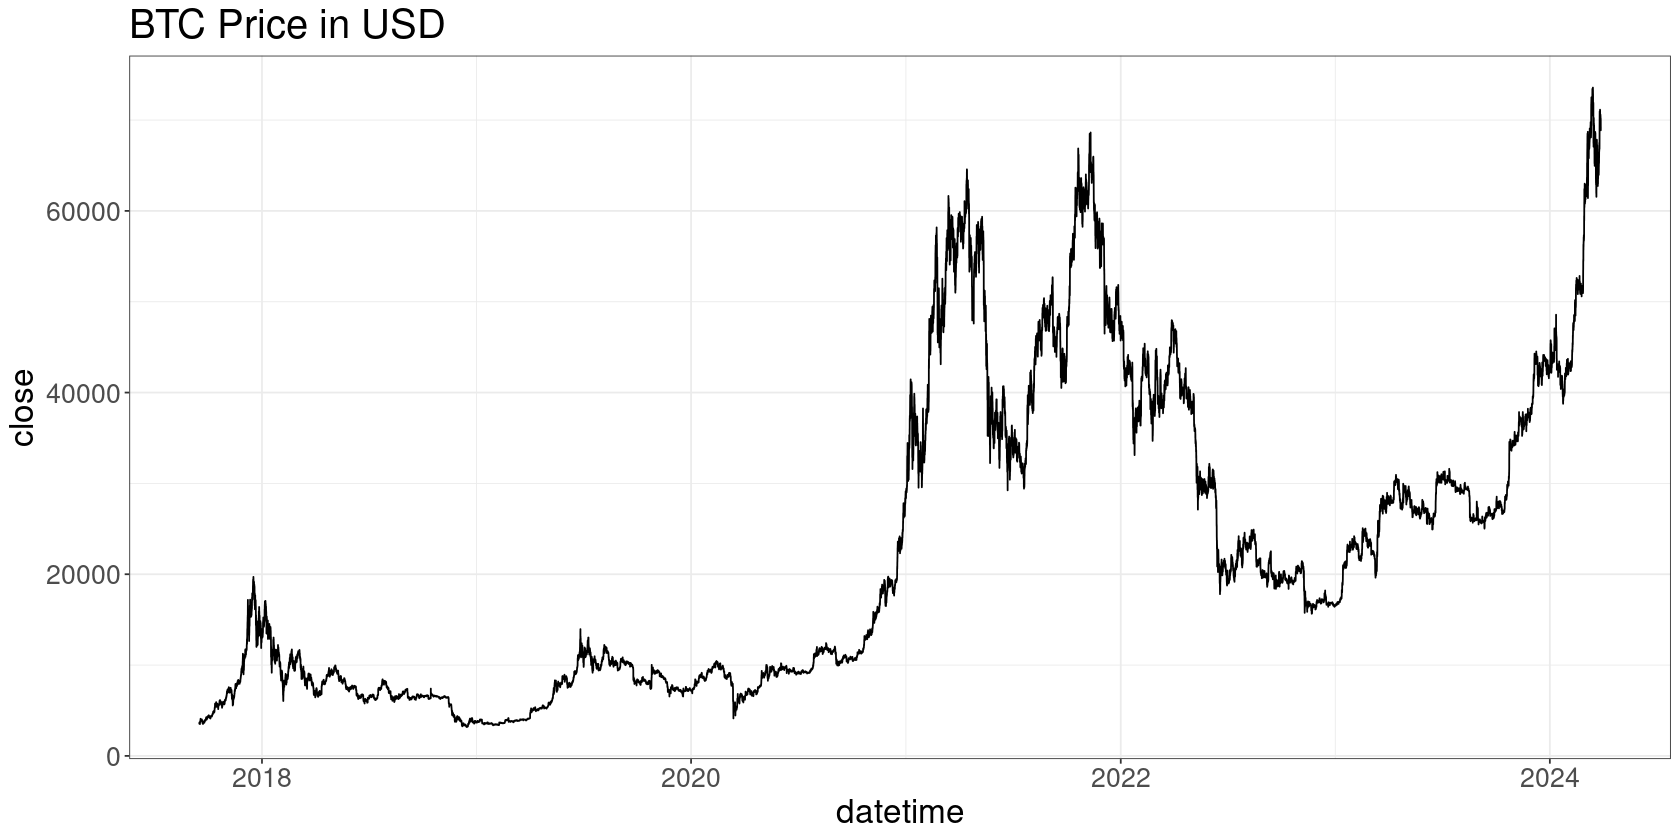

In [11]:
returns %>%
  filter(ticker == "BTC") %>%
  ggplot(aes(x=datetime, y=close)) +
    geom_line() +
    ggtitle('BTC Price in USD')

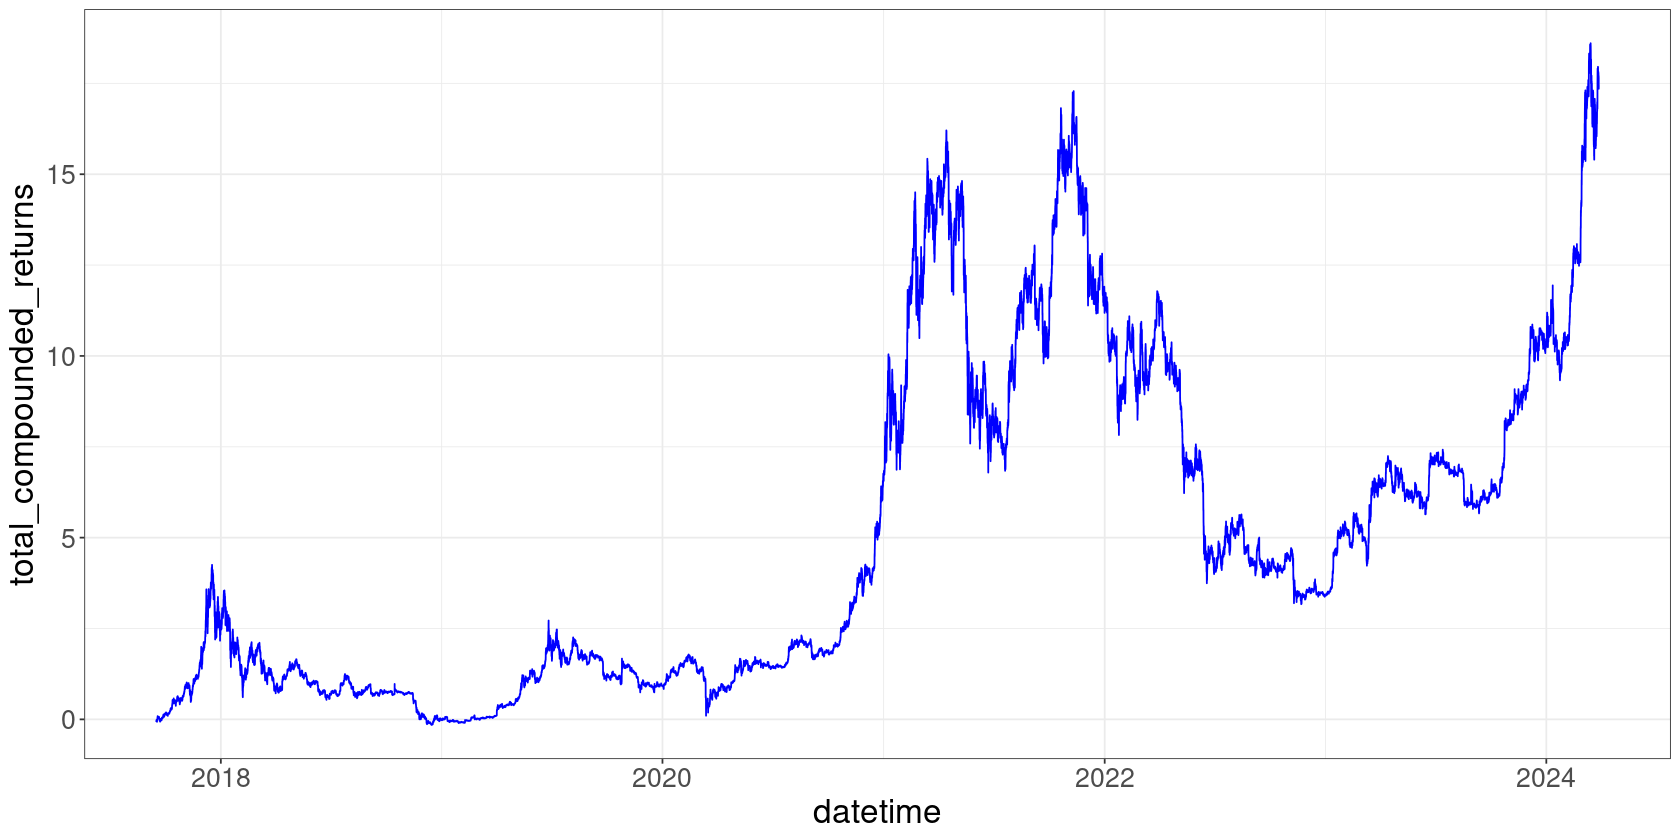

In [12]:
# window_size <- 20
returns %>%
  filter(ticker == "BTC") %>%
  mutate(
      chained_log_returns = cumsum(log_return),
      # simple_return = exp(log_return)-1,
      compounded_returns = (1 + simple_return),
      total_compounded_returns = cumprod(compounded_returns) - 1  # Subtracting 1 to show net change
  ) %>%
arrange(ticker, datetime) %>%
  ggplot() +
  geom_line(aes(x = datetime, y = total_compounded_returns), color = "blue")


## how log returns predict future returns

`geom_smooth()` using formula = 'y ~ x'


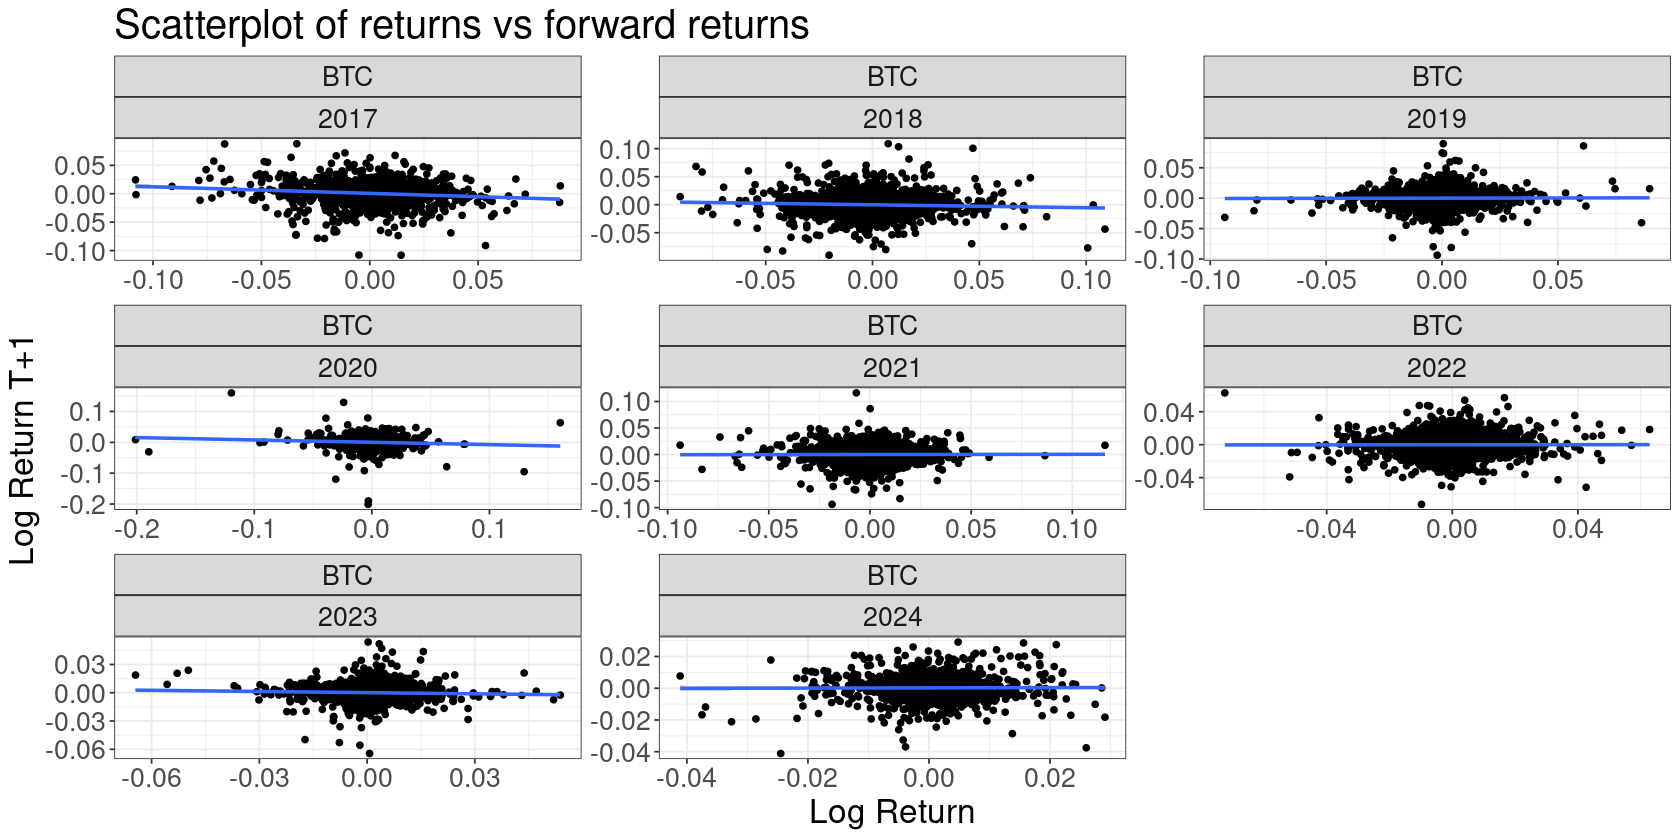

In [75]:
returns %>%
  filter(ticker %in% c("BTC")) %>%
  arrange(datetime) %>%
mutate(
    year = year(datetime),  # Extracting the year from datetime
  ) %>%
  ggplot(aes(x = log_return, y = future_log_return)) + 
    geom_point() +
    geom_smooth(method = 'lm') + 
    facet_wrap(~ticker+year, scales = 'free') +
    labs(
      title = 'Scatterplot of returns vs forward returns',
      x = 'Log Return',
      y = 'Log Return T+1'
    )

## Market aggression

### 1. Order Flow Imbalance

In [58]:
install.packages("RcppRoll")

Installing package into ‘/usr/lib64/R/library’
(as ‘lib’ is unspecified)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



# A tibble: 10 × 3
   momo_decile avg_future_return count
         <dbl>             <dbl> <int>
 1        -4.5        -0.000678  53624
 2        -3.5        -0.0000459 53633
 3        -2.5        -0.0000596 53642
 4        -1.5        -0.0000984 53648
 5        -0.5         0.0000668 53659
 6         0.5         0.0000661 53671
 7         1.5        -0.0000900 53679
 8         2.5         0.000143  53687
 9         3.5         0.000319  53699
10         4.5         0.000501  53716
# A tibble: 10 × 3
   delta_decile avg_future_return count
          <dbl>             <dbl> <int>
 1         -4.5        -0.0000480 53624
 2         -3.5        -0.000123  53633
 3         -2.5        -0.0000988 53642
 4         -1.5        -0.000135  53648
 5         -0.5        -0.0000785 53659
 6          0.5        -0.0000555 53671
 7          1.5         0.0000559 53679
 8          2.5         0.0000435 53687
 9          3.5         0.0000968 53699
10          4.5         0.000467  53716


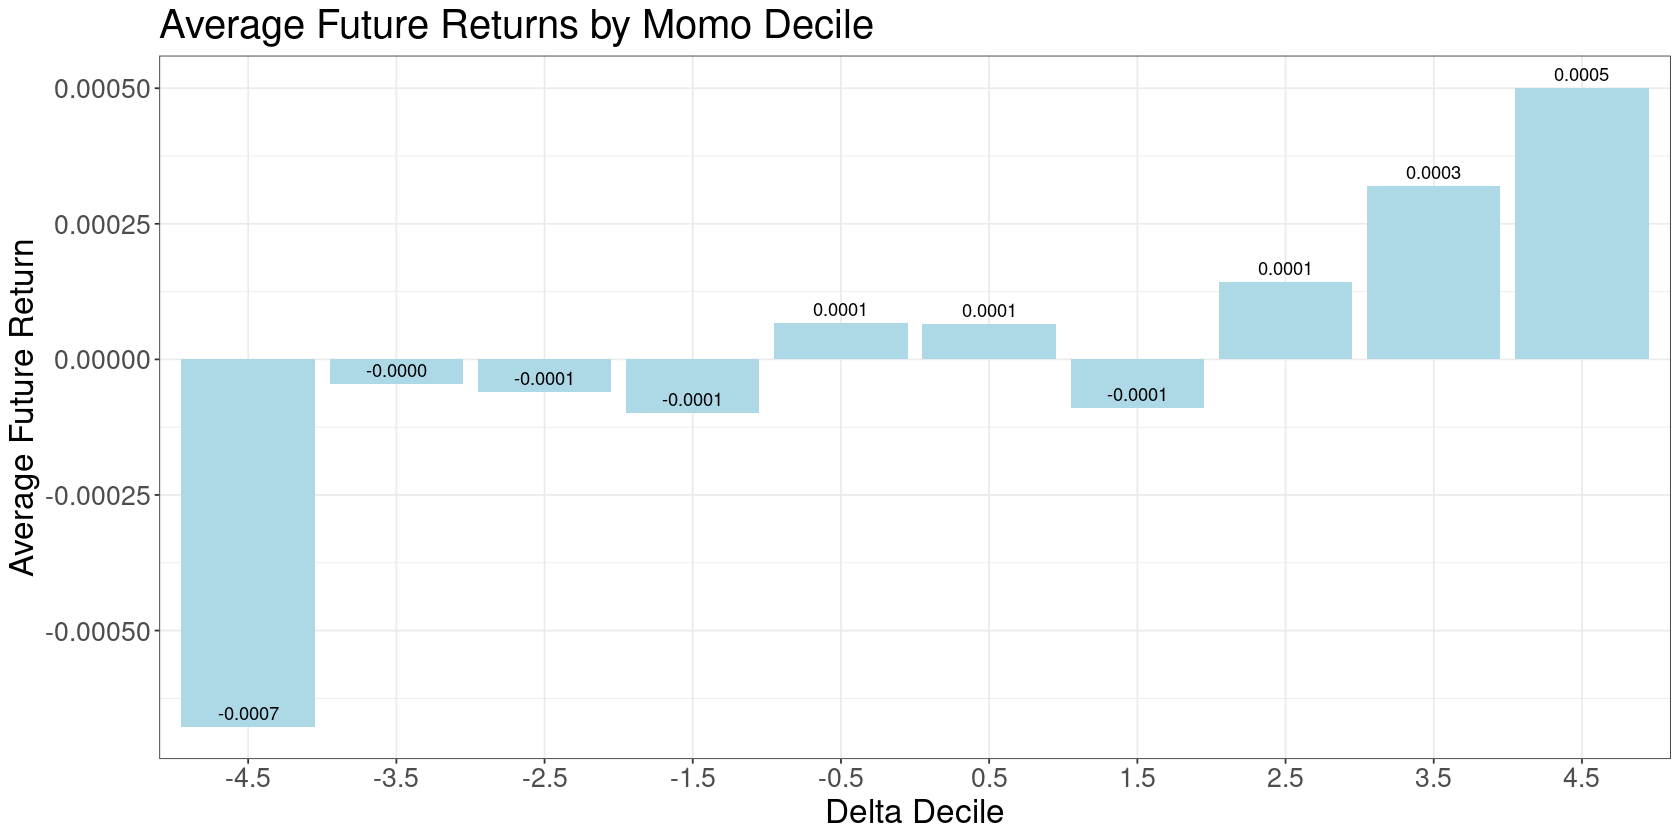

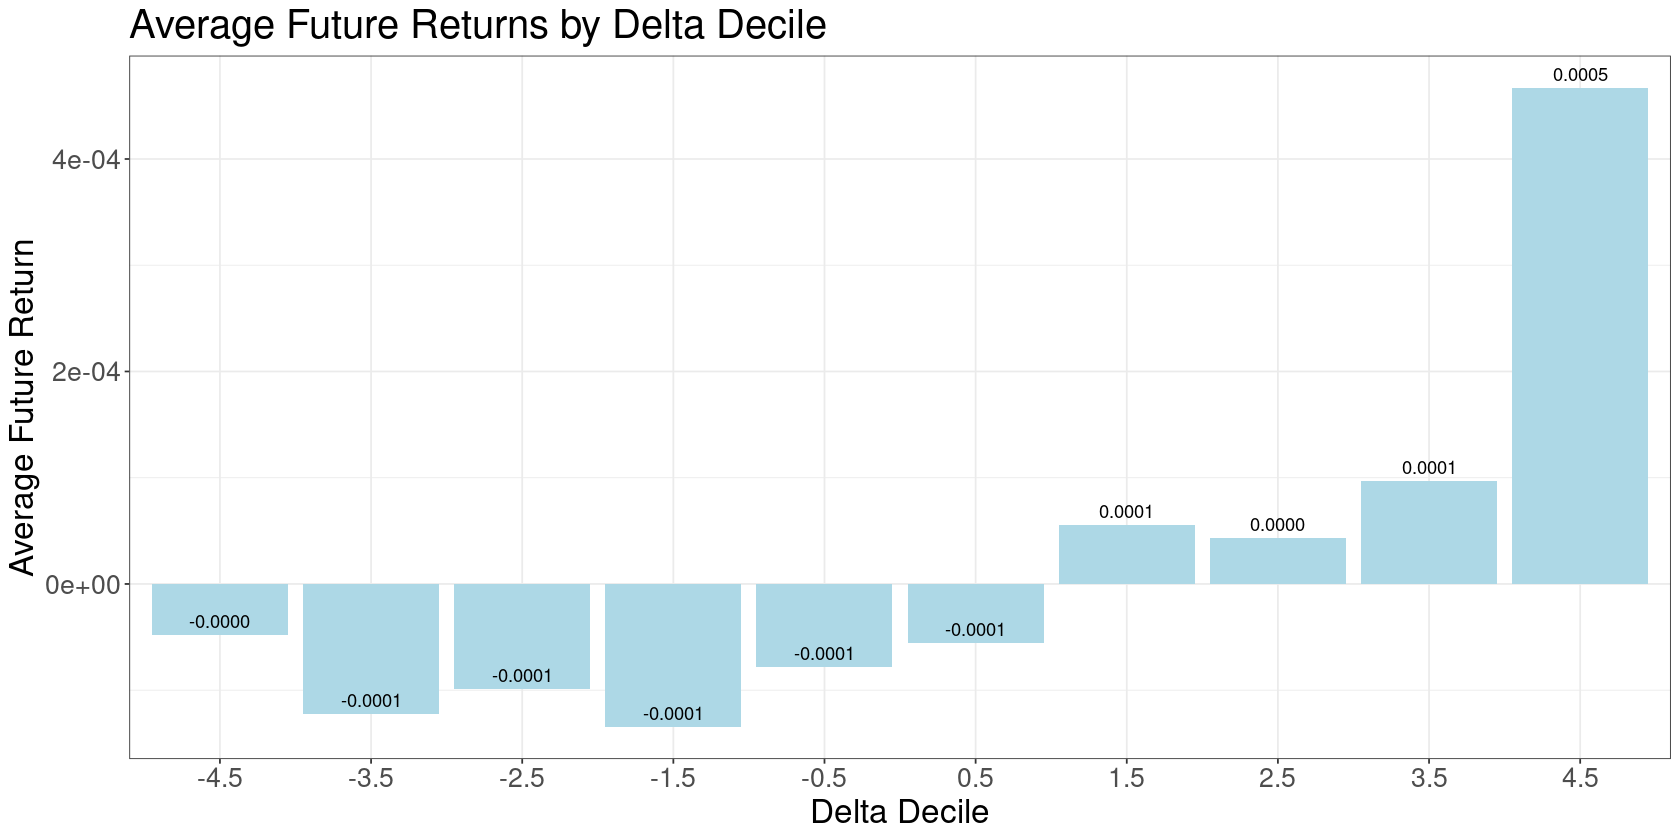

In [140]:
returns <- universe_delta %>%
  # filter( ticker == "ETH") %>%
  # filter( ticker == "BTC") %>%
  group_by(ticker) %>%
  arrange(datetime) %>%
  mutate(
    hour = lubridate::hour(datetime),
    year = lubridate::year(datetime),
    simple_return = (close / lag(close) - 1),
    log_return = log(close / lag(close)),
    future_simple_return = (lead(close) / close - 1),
    future_simple_return_3 = (lead(close, 3) / close - 1),
    future_log_return = log(lead(close) / close),
  ) %>%
  na.omit() %>% ungroup()

# Step 1: define aggression factors
returns <- returns %>%
  arrange(datetime) %>%
  group_by(ticker) %>% # no need to group if calculations are made without lag/lead rows
  mutate(
      # Order Flow Imbalance=Buy Volume−Sell Volume
      imbalance = ask - bid,
      # Bid-Delta Proportion
      bid_delta_proportion = bid / abs(delta),
      # other weights for testing
      momo = close - lag(close, 10)/close,
      # carry = funding_rate,
  ) %>%
  na.omit()# %>% ungroup()

# Step 2: Split into ntiles - for example, deciles
returns <- returns %>%
  # arrange(bid_delta_proportion) %>%
  mutate(
    bid_delta_proportion_decile = 5.5 - ntile(bid_delta_proportion, 10),
    delta_decile = 5.5 - ntile(imbalance, 10),
    momo_decile = 5.5 - ntile(momo, 10),
  )

# Step 3: Analyze how momo deciles predict future returns
# Using summarise to get average future return per decile
analysis <- returns %>%
  group_by(momo_decile) %>%
  summarise(
    avg_future_return = mean(future_log_return, na.rm = TRUE),
    count = n()
  ) %>%
  ungroup()
print(analysis)
ggplot(analysis, aes(x = as.factor(momo_decile), y = avg_future_return)) +
  geom_col(fill = "lightblue") +
  geom_text(aes(label = sprintf("%.4f", avg_future_return)), vjust = -0.5) +
  labs(
    title = "Average Future Returns by Momo Decile",
    x = "Delta Decile",
    y = "Average Future Return"
  )

# Step 3: Analyze how delta deciles predict future returns
# Using summarise to get average future return per decile
analysis <- returns %>%
  group_by(delta_decile) %>%
  summarise(
    avg_future_return = mean(future_log_return, na.rm = TRUE),
    count = n()
  ) %>%
  ungroup()
print(analysis)
ggplot(analysis, aes(x = as.factor(delta_decile), y = avg_future_return)) +
# ggplot(analysis, aes(x = as.factor(delta_decile), y = avg_future_return)) +
  geom_col(fill = "lightblue") +
  geom_text(aes(label = sprintf("%.4f", avg_future_return)), vjust = -0.5) +
  labs(
    title = "Average Future Returns by Delta Decile",
    x = "Delta Decile",
    y = "Average Future Return"
  )
# # same with points
# returns %>%
#   group_by(delta_decile) %>%
#   summarize(avg_future_return = mean(future_log_return, na.rm = TRUE)) %>%
#   ggplot(aes(x=as.factor(delta_decile), y=avg_future_return)) + geom_point()

# # every year
# returns %>%
#   group_by(year, delta_decile) %>%
#   summarise(
#     avg_future_return = mean(future_log_return, na.rm = TRUE),
#     count = n()
#   ) %>%
#   ggplot(aes(x=as.factor(delta_decile), y=avg_future_return)) + geom_point() + facet_wrap(~year, scales='free') +
#     ggtitle('Mean returns by year', subtitle = 'Average Future Returns By Delta Decile and Year')


### returns performance weigthed by all features

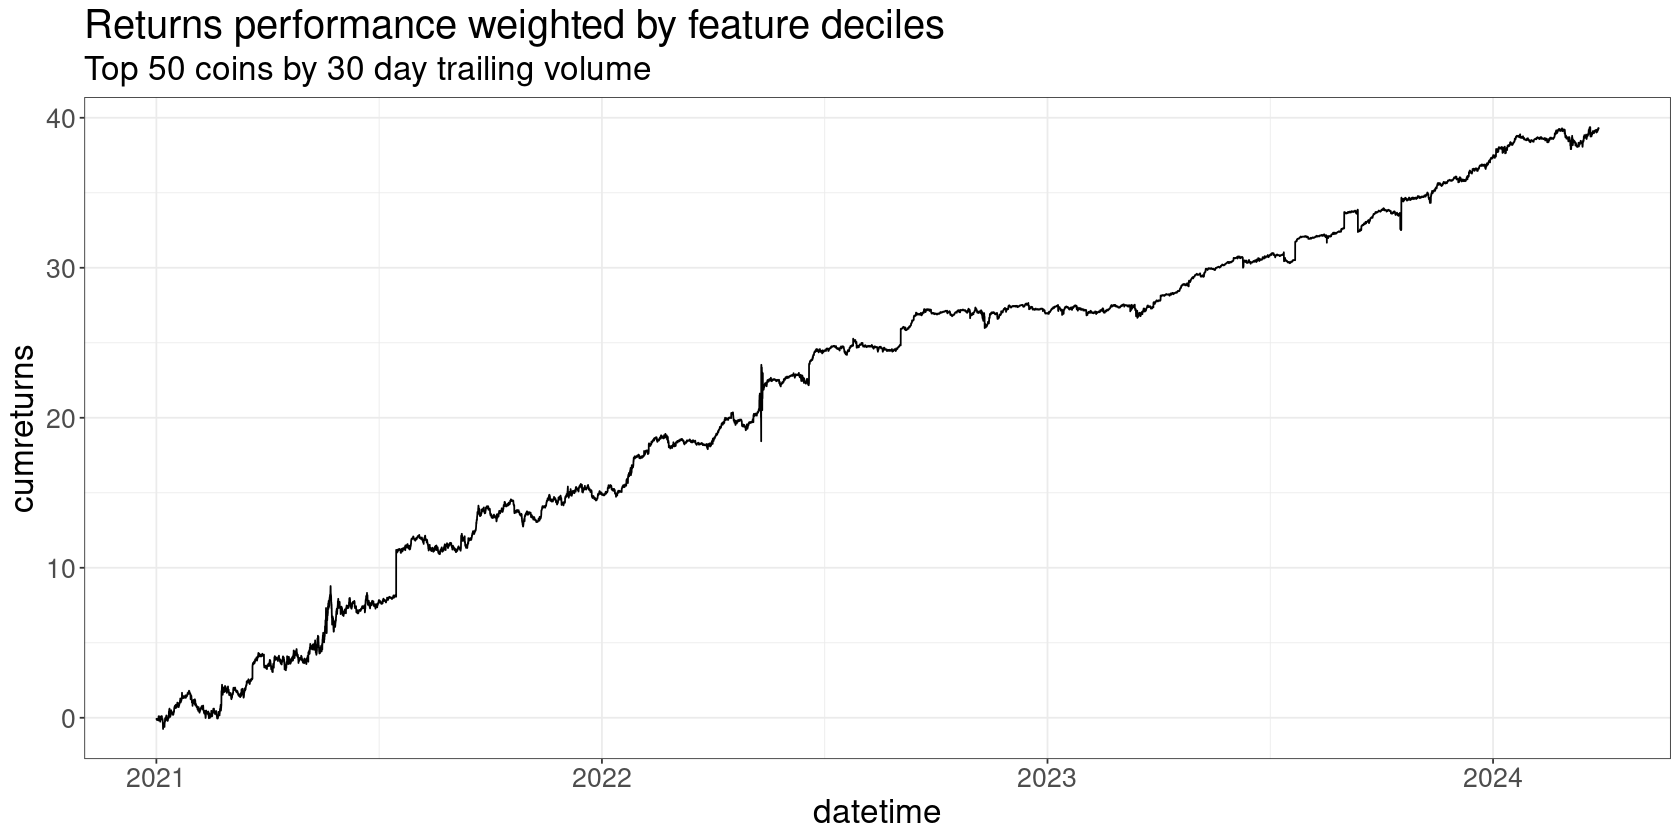

In [141]:
returns %>%
  # filter( ticker == "ETH") %>%
  # filter( ticker == "BTC") %>%
  # filter( ticker == "SOL") %>%
  filter(datetime >= '2021-01-01') %>%
  # filter(is_universe) %>%
  # mutate(date = as.Date(Datetime)) %>%
  mutate(weight = delta_decile) %>%
  # mutate(strat_return = future_simple_return*delta_decile) %>%
  # mutate(strat_return = case_when(delta_decile>0 ~ future_simple_return, TRUE ~ -future_simple_return) ) %>%
  # mutate(weight = delta_decile + bid_delta_proportion_decile) %>%
  mutate(
      weight = delta_decile + bid_delta_proportion_decile + momo_decile,
      # weight = delta_decile + bid_delta_proportion_decile,
      # weight = (delta_decile + bid_delta_proportion_decile)/4.5,
      # weight = delta_decile/4.5,
      # weight = bid_delta_proportion_decile/4.5,
      strat_return = weight * future_simple_return,
  ) %>%
  group_by(datetime) %>%
  summarize(mean_returns = mean(strat_return)) %>%
  arrange(datetime) %>%
  mutate(cumreturns = cumsum(mean_returns)) %>%
  ggplot(aes(x=datetime, y=cumreturns)) + geom_line() +
  ggtitle('Returns performance weighted by feature deciles', subtitle = 'Top 50 coins by 30 day trailing volume')


### weight decile

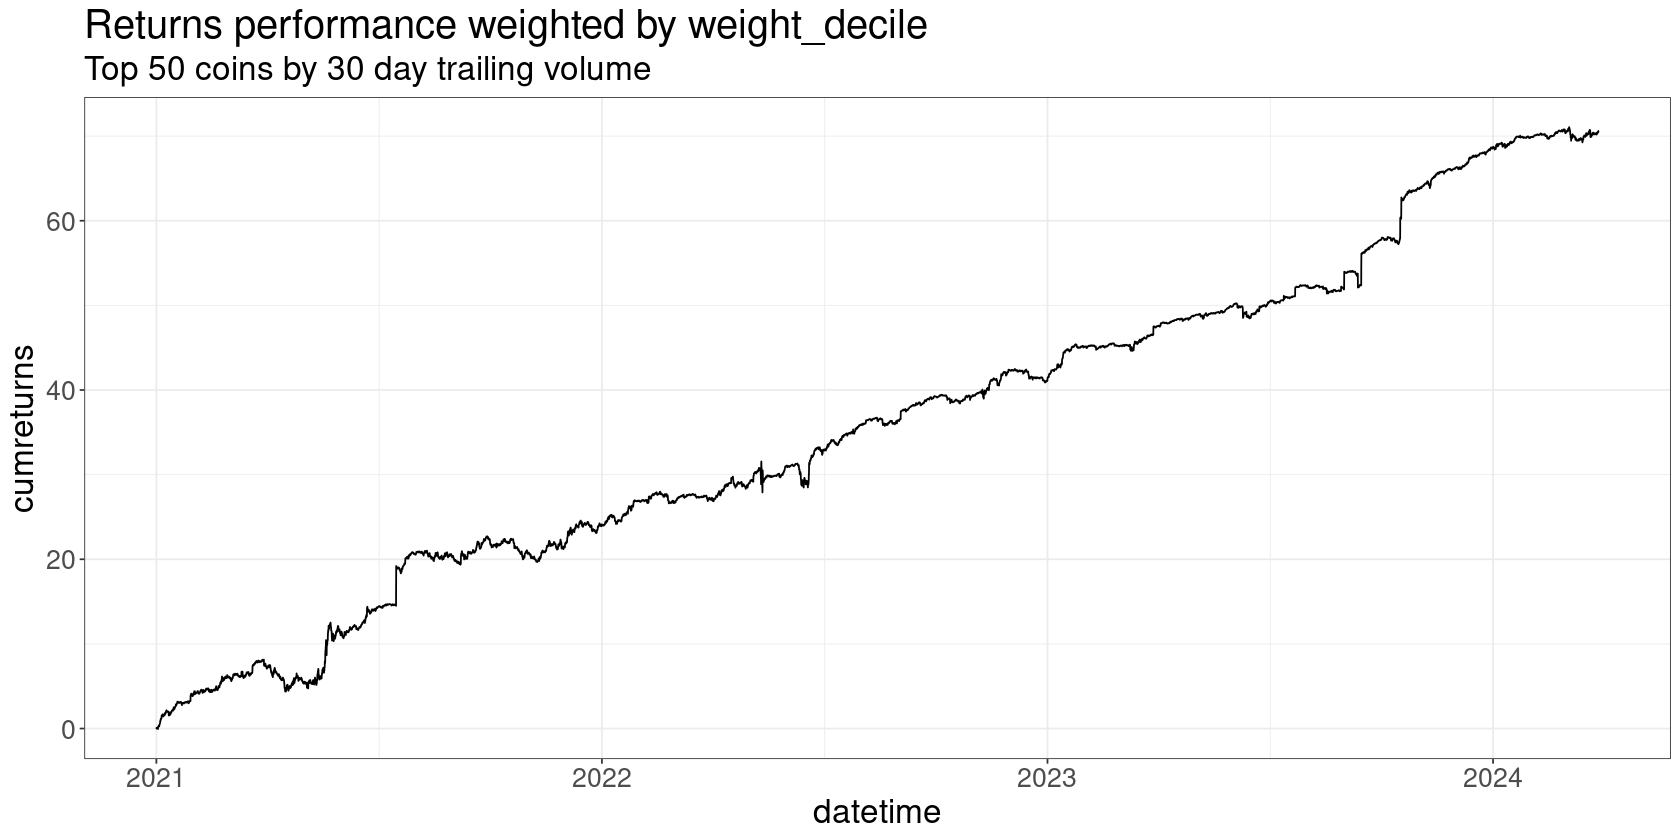

In [143]:
# weight decile
# weight_decile_returns <- returns %>%
returns %>%
  # filter( ticker == "ETH") %>%
  # filter( ticker == "BTC") %>%
  # filter( ticker == "SOL") %>%
  filter(datetime >= '2021-01-01') %>%
  mutate(
      weight = delta_decile + bid_delta_proportion_decile + momo_decile*2,
      # weight = delta_decile + bid_delta_proportion_decile,
      # weight = (delta_decile + bid_delta_proportion_decile)/4.5,
      # weight = delta_decile/4.5,
      # weight = bid_delta_proportion_decile/4.5,
      # strat_return = weight * future_simple_return,
  ) %>%
  mutate(
    weight_decile = 5.5 - ntile(weight, 10),
  ) %>%
  mutate(
      weight2 = -weight_decile,
      # weight2 = -case_when(weight_decile < -3 ~ -3, weight_decile > 3 ~ 3, TRUE ~ 0),
      # weight = delta_decile + bid_delta_proportion_decile,
      # weight = (delta_decile + bid_delta_proportion_decile)/4.5,
      # weight = delta_decile/4.5,
      # weight = bid_delta_proportion_decile/4.5,
      strat_return = weight2 * future_simple_return_3,
  ) %>%
  group_by(datetime) %>%
  summarize(mean_returns = mean(strat_return)) %>%
  arrange(datetime) %>%
  mutate(cumreturns = cumsum(mean_returns)) %>%
  ggplot(aes(x=datetime, y=cumreturns)) + geom_line() +
  ggtitle('Returns performance weighted by weight_decile', subtitle = 'Top 50 coins by 30 day trailing volume')
